In [295]:
%matplotlib inline
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
def mard(df, c1, c2):
    a = abs(df[c1]-df[c2])/(df[c1]+df[c2])
    return a.sum()/a.count()

# Loading Reference name to Taxa Id file

In [4]:
ref = "/mnt/scratch2/avi/meta-map/kraken/KrakenDB/seqid2taxid.map"
with open(ref) as f:
    refId2TaxId = pd.read_csv(f, header=None, sep="\t", names=["refName", "refId"])

In [420]:
refId2TaxId[refId2TaxId.refId == 964]

,refName,refId


In [416]:
refId2TaxId[refId2TaxId.refName == 'gi|330822653|ref|NC_015422.1']

,refName,refId


# Loading Taxonomy Tree
### Taxum ID , Taxum Rank , Taxum Parent ID

In [44]:
tf = "/mnt/scratch2/avi/meta-map/kraken/KrakenDB/taxonomy/nodes.dmp"
taxa = []
id2rank = {}
with open(tf) as f:
    for line in f:
        toks = line.rstrip("\t|\n").split("\t|\t")
        taxa += [[int(toks[0]), int(toks[1]), toks[2]]]
        id2rank[int(toks[0])] = toks[2]
taxa_df = pd.DataFrame.from_records(taxa)
taxa_df.columns = ["taxaId", "pid", "rank"]

In [45]:
taxa_df.head()

,taxaId,pid,rank
0,1,1,no rank
1,2,131567,superkingdom
2,6,335928,genus
3,7,6,species
4,9,32199,species


In [51]:
test = taxa_df.groupby('taxaId').count()
test

,pid,rank
taxaId,,
1,1,1
2,1,1
6,1,1
7,1,1
9,1,1
10,1,1
11,1,1
13,1,1
14,1,1


In [421]:
a = taxa_df[taxa_df.taxaId == 964]
a

,taxaId,pid,rank
742,964,963,species


# List of Leaves

Right join of **pid** and **cid** (parent and child)
And then looking for any child that has never been a parent : with parent = **nan**

In [74]:
leaves = pd.merge(taxa_df[['pid']], taxa_df[['taxaId', 'rank']], left_on='pid', right_on='taxaId', how='right')

In [75]:
leaves = leaves[np.isnan(leaves['pid'])][['taxaId', 'rank']]
print(len(leaves))
leaves.head()

1528122


,taxaId,rank
1669515,25,species
1669516,27,species
1669517,28,species
1669518,38,species
1669519,45,species


# List of Roots
Left join of **pid** and **cid** (parent and child) And then looking for any parent that is never a child : child = **nan** parent

In [81]:
roots = pd.merge(taxa_df[['pid', 'rank']], taxa_df[['taxaId', 'pid']], left_on='pid', right_on='taxaId', how='left')
#roots = roots[np.isnan(roots['taxaId'])][['pid', 'rank']]
roots[roots['taxaId'] == roots['pid_y']]

,pid_x,rank,taxaId,pid_y
0,1,no rank,1,1
8284,1,superkingdom,1,1
9909,1,superkingdom,1,1
9931,1,no rank,1,1
12110,1,no rank,1,1
101269,1,no rank,1,1


In [78]:
c2p = {}
c2pid = {}
with open(tf) as f:
    for line in f:
        toks = line.rstrip("\t|\n").split("\t|\t")
        c2pid[int(toks[0])] = int(toks[1])
        if id2rank[int(toks[0])] not in c2p:
            c2p[id2rank[int(toks[0])]] = set()
        c2p[id2rank[int(toks[0])]].add(id2rank[int(toks[1])])

# Child -> Parent

In [24]:
for key, value in c2p.items():
    print ('{} --> parent list:'.format(key))
    print(value)
    print('\n')

no rank --> parent list:
{'genus', 'no rank', 'superorder', 'species subgroup', 'superclass', 'infraorder', 'superfamily', 'tribe', 'superkingdom', 'parvorder', 'subtribe', 'suborder', 'cohort', 'subspecies', 'species', 'phylum', 'infraclass', 'order', 'varietas', 'subphylum', 'subfamily', 'subclass', 'family', 'subkingdom', 'class', 'forma', 'species group', 'subgenus', 'kingdom'}


superkingdom --> parent list:
{'no rank'}


genus --> parent list:
{'no rank', 'suborder', 'family', 'class', 'phylum', 'infraclass', 'order', 'superkingdom', 'subtribe', 'superfamily', 'tribe', 'subfamily', 'subphylum', 'subclass'}


species --> parent list:
{'genus', 'no rank', 'suborder', 'family', 'class', 'species', 'phylum', 'species subgroup', 'species group', 'order', 'subgenus', 'superfamily', 'tribe', 'subfamily', 'subclass'}


order --> parent list:
{'no rank', 'superorder', 'cohort', 'class', 'phylum', 'infraclass', 'subphylum', 'superkingdom', 'subclass'}


family --> parent list:
{'no rank', 

# ranks

In [12]:
print(len(taxa_df['rank'].unique()))
taxa_df['rank'].unique()

30


array(['no rank', 'superkingdom', 'genus', 'species', 'order', 'family',
       'subspecies', 'subfamily', 'tribe', 'phylum', 'class', 'forma',
       'suborder', 'subclass', 'varietas', 'kingdom', 'subphylum',
       'superfamily', 'infraorder', 'infraclass', 'superorder', 'subgenus',
       'superclass', 'parvorder', 'superphylum', 'species group',
       'species subgroup', 'cohort', 'subtribe', 'subkingdom'], dtype=object)

# Both Parent and Child at the same time in the reference list? 
## yes!

In [87]:
ref2taxaLevel = pd.merge(refId2TaxId, taxa_df, left_on="refId", right_on="taxaId")
print(len(refId2TaxId))
print(len(ref2taxaLevel))
ref2taxaLevel.head()

4815
4815


,refName,refId,taxaId,pid,rank
0,gi|9791176|ref|NC_002180.1|,1986029,1986029,40274,species
1,gi|10803547|ref|NC_001869.1|,64091,64091,2242,no rank
2,gi|15789340|ref|NC_002607.1|,64091,64091,2242,no rank
3,gi|16119979|ref|NC_002608.1|,64091,64091,2242,no rank
4,gi|10954488|ref|NC_001732.1|,243232,243232,2190,no rank


In [149]:
ref2taxaLevel[ref2taxaLevel['taxaId'] == 680]

,refName,refId,taxaId,pid,rank


In [27]:
a = set()
for t in ref2taxaLevel.taxaId:
    a.add(t)

In [29]:
b = set()
for t in ref2taxaLevel.taxaId:
    b.add(c2pid[t])

List of reference taxa that are parents of some children in the same list

In [30]:
a.intersection(b)

{316,
 340,
 813,
 1148,
 1604,
 1639,
 2110,
 29447,
 40041,
 91891,
 107806,
 190650,
 192222,
 196627,
 208964,
 523796,
 543891,
 869727,
 907287,
 941967,
 1001534,
 1071763,
 1263406,
 1283330,
 1306414}

# Reference Rank Distribution
### Note: Not all the "no rank"s are the same!!

In [42]:
ref2taxaLevel.groupby('rank').count()

,refName,refId,taxaId
rank,,,
no rank,4336,4336,4336
species,465,465,465
subspecies,14,14,14


# Analysis of the truth 

In [108]:
truthfile = '/mnt/scratch2/avi/meta-map/kraken/meta/truth.txt'
truth = pd.read_csv(truthfile, sep="\t")

In [115]:
truth.head()

,taxid,counts,species,size,dataset
0,79329,24666,Chitinophaga pinensis,9127347,Huttenhower_HC1
1,1836,22195,Saccharopolyspora erythraea,8079083,Huttenhower_HC1
2,152480,20654,Burkholderia ambifaria,8095900,Huttenhower_HC1
3,182640,20483,Kribbella flavida,7579488,Huttenhower_HC1
4,80866,18289,Delftia acidovorans,6823175,Huttenhower_HC1


In [121]:
hc1_truth = truth[truth['dataset'] == 'Huttenhower_HC1']
len(hc1_truth)

100

In [126]:
hc1 = pd.merge(hc1_truth, taxa_df, left_on='taxid', right_on='taxaId')
hc1 = hc1[['taxaId', 'rank', 'counts']]
hc1.columns = [['trueId', 'rank', 'trueCount']]
len(hc1)

100

In [127]:
hc1.iloc[:,0]

0      79329
1       1836
2     152480
3     182640
4      80866
5        986
6        680
7     160791
8       1396
9       2214
10       329
11      2296
12      1428
13    271097
14     28151
15     80867
16      1764
17       408
18    244366
19    404011
20       354
21      1108
22       670
23       672
24       339
25    131568
26    470934
27      2208
28       553
29    152260
       ...  
70      1717
71      1100
72       837
73     69966
74    121277
75       274
76    311400
77      1587
78     55802
79    187878
80      2421
81     33959
82      1094
83      1314
84       727
85      2277
86     32025
87      1308
88      2317
89       217
90       212
91     64160
92     83171
93      2180
94       786
95       769
96    664662
97     50052
98      2130
99    186490
Name: trueId, Length: 100, dtype: int64

In [130]:
a = hc1.iloc[0, :]
a

trueId         79329
rank         species
trueCount      24666
Name: 0, dtype: object

In [133]:
a.iloc[1]

'species'

### Everything has been simulated from "species" level

In [86]:
truth['rank'].unique()

array(['species'], dtype=object)

In [93]:
for dataset in ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']:
    print('\n{}'.format(dataset))
    hc1 = truth[truth.dataset == 'Huttenhower_'+dataset]
    #print(hc1['counts'].sum())
    krakmap_out = '~/projects/pufferfish/build/'+dataset+'_species.out'
    avi_krakmap_file = '/mnt/scratch2/avi/meta-map/kraken/puff/fat_out/species/'+dataset+'_report.txt'
    krakmap = pd.read_csv(krakmap_out, sep="\t")
    #print(krakmap['count'].sum())
    krakmap = krakmap[krakmap['taxaId'] != 0]
    #print(krakmap['count'].sum())
    #print('fatal original count : {}'.format(len(krakmap['count'])))
    avi_krakmap = pd.read_csv(avi_krakmap_file, sep='\t')
    #print(avi_krakmap['Count'].sum())
    avi_krakmap = avi_krakmap[avi_krakmap['Feature'] != 0]
    #print(avi_krakmap['Count'].sum())
    #avi_krakmap = avi_krakmap[avi_krakmap['Feature'] != 0]
    #print('avi original count: {}'.format(len(avi_krakmap)))
    avi_krakmap = pd.merge(avi_krakmap, taxa_df, left_on='Feature', right_on='taxaId')
    #print('count after merging to get ranks (should be the same): {}'.format(len(avi_krakmap)))
    fatal_species = krakmap[krakmap.taxaRank == 'species']
    avi_species = avi_krakmap[avi_krakmap['rank'] == 'species']
    #print('fatal count of species : {}'.format(len(krakmap_species)))
    #print('avi count of species : {}'.format(len(avi_krakmap)))
    pythcppjoined = pd.merge(krakmap, avi_krakmap, left_on='taxaId', right_on='Feature', how='outer').fillna(0)
    #print('Fatal vs Avi')
    #print(spearmanr(pythcppjoined['count'], pythcppjoined['Count']))
    #print('mard: {}'.format(mard(pythcppjoined, 'count', 'Count')))
    #pythcppjoined['diff'] = pythcppjoined['count']-pythcppjoined['Count']
    #print(pythcppjoined[pythcppjoined['diff'] != 0][['taxaId_x', 'Feature', 'taxaRank', 'rank', 'Count', 'diff']])
    #print('avi # of reads: {}'.format(avi_krakmap['Count'].sum()))
    #print('fatal # of reads: {}'.format(krakmap_species['count'].sum()))
    kraktruthjoined = pd.merge(hc1, fatal_species, left_on='taxid', right_on='taxaId', how='outer').fillna(0)
    print('FatalTruth')
    print(kraktruthjoined[['counts', 'count']].corr(method='spearman'))
    print('mard: {}'.format(mard(kraktruthjoined, 'counts', 'count')))
    #print('diff:')
    #kraktruthjoined['diff'] = kraktruthjoined['counts']-kraktruthjoined['count']
    #print(kraktruthjoined[['taxid','diff']])
    pythtruthjoined = pd.merge(hc1, avi_species, left_on='taxid', right_on='Feature', how='outer').fillna(0)
    print('AviTruth')
    print(pythtruthjoined[['counts', 'Count']].corr(method='spearman'))
    print('mard: {}'.format(mard(pythtruthjoined, 'counts', 'Count')))
    #print(pythtruthjoined['counts']-pythtruthjoined['Count'])


HC1
FatalTruth
          counts     count
counts  1.000000  0.836454
count   0.836454  1.000000
mard: 0.6913114348184081
AviTruth
          counts     Count
counts  1.000000  0.836454
Count   0.836454  1.000000
mard: 0.6913123818230174

HC2
FatalTruth
          counts     count
counts  1.000000  0.834336
count   0.834336  1.000000
mard: 0.7182558021375831
AviTruth
          counts     Count
counts  1.000000  0.834336
Count   0.834336  1.000000
mard: 0.7182567741469842

LC1
FatalTruth
         counts    count
counts  1.00000  0.74018
count   0.74018  1.00000
mard: 0.6656522271730764
AviTruth
         counts    Count
counts  1.00000  0.74018
Count   0.74018  1.00000
mard: 0.6656527419465809

LC2
FatalTruth
          counts     count
counts  1.000000  0.887078
count   0.887078  1.000000
mard: 0.6422944277191631
AviTruth
          counts     Count
counts  1.000000  0.887078
Count   0.887078  1.000000
mard: 0.6422944277191631

LC3
FatalTruth
          counts     count
counts  1.000000  0.8

In [57]:
truthf = '/mnt/scratch2/avi/meta-map/kraken/puff/fat_out/krakOut/truth_report.txt'
krakenf = '/mnt/scratch2/avi/meta-map/kraken/puff/fat_out/krakOut/krak_report.txt'
pythkrakf = ''
cppkrakf = '/home/fatemeh/projects/pufferfish/build/HC1_phylum_44.out'
kraken = pd.read_csv(krakenf, sep='\t')
kraken = kraken[kraken['Count'] != 0]
print(len(kraken))
cppkrak = pd.read_csv(cppkrakf, sep='\t')
print(len(cppkrak))
truth = pd.read_csv(truthf, sep="\t")
truth.columns = ['trueID', 'trueCount']
print(len(truth))
cppkrakkrakjoined = pd.merge(kraken, cppkrak, how='outer', left_on='Feature', right_on='taxaId').fillna(0)
cppkrakkrakjoined['diff'] = cppkrakkrakjoined['Count']-cppkrakkrakjoined['count']
cppkrakkrakjoined[['Feature', 'taxaId', 'taxaRank', 'Count', 'diff']]

trukrakjoined = pd.merge(kraken, truth, how='outer', left_on='Feature', right_on='trueID').fillna(0)
trukrakjoined['diff'] = trukrakjoined['trueCount']-trukrakjoined['Count']
trukrak = trukrakjoined[['trueID', 'Feature', 'trueCount', 'Count', 'diff']]
trukrak = pd.merge(trukrak, taxa_df, how='inner', left_on='Feature', right_on='taxaId')[['trueID', 'Feature', 'rank', 'trueCount', 'Count', 'diff']]
print(trukrak[['trueCount', 'Count']].corr(method='spearman'))
print(trukrak[trukrak['trueID'] == 0])

cppkrak = cppkrak[cppkrak['taxaRank'] != 'life']
trucppkrakjoined = pd.merge(cppkrak, truth, how='outer', left_on='taxaId', right_on='trueID').fillna(0)
trucppkrakjoined['diff'] = trucppkrakjoined['trueCount']-trucppkrakjoined['count']
trupuff = trucppkrakjoined[['trueID', 'taxaId', 'taxaRank', 'trueCount', 'count', 'diff']]
print(trupuff[['trueCount', 'count']].corr(method='spearman'))

print(trupuff_nolife[trupuff_nolife['trueID'] == 0])

shared = pd.merge(cppkrak, truth, how='inner', left_on='taxaId', right_on='trueID')
shared = pd.merge(kraken, shared, how='inner', left_on='Feature', right_on='trueID')
print(shared[['trueID', 'trueCount', 'Count', 'count' ]])
print(shared[['trueCount', 'count', 'Count']].corr())

23
19
14
           trueCount     Count
trueCount   1.000000  0.969843
Count       0.969843  1.000000
    trueID  Feature          rank  trueCount  Count   diff
0      0.0        2  superkingdom        0.0    841 -841.0
4      0.0    74152        phylum        0.0      1   -1.0
7      0.0    32066        phylum        0.0      1   -1.0
9      0.0    68297        phylum        0.0      1   -1.0
18     0.0  1783270       no rank        0.0      3   -3.0
19     0.0  1783272       no rank        0.0    107 -107.0
20     0.0     2157  superkingdom        0.0      4   -4.0
21     0.0   131567       no rank        0.0     22  -22.0
22     0.0    68336       no rank        0.0      2   -2.0
           trueCount     count
trueCount   1.000000  0.992752
count       0.992752  1.000000
    trueID   taxaId      taxaRank  trueCount  count  diff
1      0.0   131567       no rank        0.0      3  -3.0
6      0.0  1783272       no rank        0.0     11 -11.0
7      0.0        2  superkingdom        

In [232]:
def calc_precRecall(truth_pred):
    alltruth = truth_pred['trueCount'].sum()
    tp = truth_pred[['predCount', 'trueCount']].min(axis=1).sum()
    recall = tp/alltruth
    prediction = truth_pred['predCount'].sum()
    prec = tp/prediction
    f1 = 2*(prec*recall)/(prec+recall)
    return [prec, recall, f1]

In [230]:
# assumption:
# 0: id, 1: rank, 2: count
def aggregate(taxa_df, df, level = 'species', keepAll = False):
    res = defaultdict(lambda:0, {})
    for index, row in df.iterrows():
        node = [row.iloc[0], row.iloc[1], row.iloc[2]]
        while (node[1] != level and node[0] != 1):
            parId = taxa_df[taxa_df['taxaId'] == node[0]].pid.values[0]
            pnode = taxa_df[taxa_df['taxaId'] == parId]
            node = [pnode.taxaId.values[0], pnode['rank'].values[0], node[2]]
        if node[1] == level:
            res[node[0]] += node[2]
    return pd.DataFrame(list(res.items()), columns=['id', 'count'])

In [342]:
def prepare(krakenf, pufferf):
    stats = []
    #hc1_truth = {}
    #hc1_puffer = {}
    #hc1_kraken = {}
    for dataset in ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']:
        print(dataset)
    #     dataset_truth = truth[truth['dataset'] == 'Huttenhower_{}'.format(dataset)]
    #     dataset_truth = pd.merge(dataset_truth, taxa_df, left_on='taxid', right_on='taxaId')
    #     dataset_truth = dataset_truth[['taxaId', 'rank', 'counts']]
    #     dataset_truth.columns = [['trueId', 'rank', 'trueCount']]

        #krakenf = '/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt'.format(dataset)
        krakenf = krakenf.format(dataset)
        kraken = pd.read_csv(krakenf, sep="\t", header=None)
        kraken.columns = ['totalPerc', 'totalCount', 'count', 'r', 'id', 'rankScientificName']
        kraken = kraken[['id', 'count']]
        kraken = pd.merge(kraken, taxa_df, left_on='id', right_on='taxaId')
        kraken = kraken[['id','rank', 'count']]

        #pufferf = '/mnt/scratch2/fatemeh/krakpuff/{}_species0_2.out'.format(dataset)
        pufferf = pufferf.format(dataset)
        puffer = pd.read_csv(pufferf, sep="\t")
        for level in ['species', 'genus', 'family', 'order', 'class', 'phylum']:
            #print(level)
            key = dataset + '-' + level
            #hc1_truth[key] = aggregate(taxa_df, dataset_truth, level)
            hc1_puffer[key] = aggregate(taxa_df, puffer, level)
            hc1_kraken[key] = aggregate(taxa_df, kraken, level)
            hc1_truth[key].columns = ['trueId', 'trueCount']
            hc1_puffer[key].columns = ['predId', 'predCount']
            hc1_kraken[key].columns = ['predId', 'predCount']
            hc1_truth_puffer_joined = pd.merge(hc1_truth[key], hc1_puffer[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
            hc1_truth_puffer_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
            puff_pears = hc1_truth_puffer_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
            puff_spear = hc1_truth_puffer_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
            puff_mard = mard(hc1_truth_puffer_joined, 'trueCount', 'predCount')
            puff_precrecf1 = calc_precRecall(hc1_truth_puffer_joined)

            hc1_truth_kraken_joined = pd.merge(hc1_truth[key], hc1_kraken[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
            hc1_truth_kraken_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
            kraken_pears = hc1_truth_kraken_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
            kraken_spear = hc1_truth_kraken_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
            kraken_mard = mard(hc1_truth_kraken_joined, 'trueCount', 'predCount')
            kraken_precrecf1 = calc_precRecall(hc1_truth_kraken_joined)

            stats += [(dataset, level,
                    puff_pears, puff_spear, puff_mard, puff_precrecf1[0], puff_precrecf1[1], puff_precrecf1[2],
                    kraken_pears, kraken_spear, kraken_mard, kraken_precrecf1[0], kraken_precrecf1[1], kraken_precrecf1[2])]
    stats_df = pd.DataFrame.from_records(stats, columns = ['dataset', 'level', 
                                   'puff_pearson', 'puff_spearman', 'puff_mard', 'puff_prec', 'puff_rec', 'puff_f1',
                                     'kraken_pearson', 'kraken_spearman', 'kraken_mard', 'kraken_prec', 'kraken_rec', 'kraken_f1']) 
    stats_df['krakpuff_mard_diff'] = stats_df['kraken_mard']-stats_df['puff_mard']
    stats_df['puffkrak_spearman_diff'] = stats_df['puff_spearman']-stats_df['kraken_spearman']
    stats_df['puffkrak_pearson_diff'] = stats_df['puff_pearson']-stats_df['kraken_pearson']
    stats_df['puffkrak_f1_diff'] = stats_df['puff_f1']-stats_df['kraken_f1']
    return (stats_df, hc1_kraken, hc1_puffer)

# Test if aggregate up is equal to prune 

In [333]:
level = 'species'
pufferf = '/mnt/scratch2/fatemeh/krakpuff/HC1_{}_unfilt.out'.format(level)
puffer = pd.read_csv(pufferf, sep="\t")
diff = pd.merge(hc1_puffer['HC1-{}'.format(level)], puffer[puffer['taxaRank'] == level], how='outer', left_on='predId', right_on='taxaId').fillna(0)
diff['diff'] = diff['predCount'] - diff['count']
diff[diff['diff'] != 0]

,predId,predCount,taxaId,taxaRank,count,diff


In [344]:
def draw_plots(stats_df):

    datasets = ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']
    levels = ['species', 'genus', 'family', 'order', 'class', 'phylum']
    statistics = ['spearman', 'pearson', 'mard', 'f1']


    for st in statistics:
        print('\n\n{}'.format(st))
        plt.subplots(2, 3, figsize=[20, 10])
        index = np.arange(len(datasets))
        bar_width = 0.35
        opacity = 0.8

        i = 1
        for level in levels:
            plt.subplot(2, 3, i)
            plt.bar(index, stats_df[stats_df['level'] == level]['puff_{}'.format(st)], bar_width,
                             alpha=opacity,
                             color='b',
                             label='Puffer')

            plt.bar(index + bar_width, stats_df[stats_df['level'] == level]['kraken_{}'.format(st)], bar_width,
                             alpha=opacity,
                             color='g',
                             label='Kraken')

            #plt.xlabel('Datasets', fontsize=14)
            plt.ylabel(st, fontsize=20)
            #plt.title('Scores by person')
            plt.xticks(index + bar_width, stats_df[stats_df['level'] == level]['dataset'])
            plt.legend()
            plt.title(level, fontsize=22)
            i += 1
        plt.tight_layout()
        plt.show()

# No Filtering



spearman


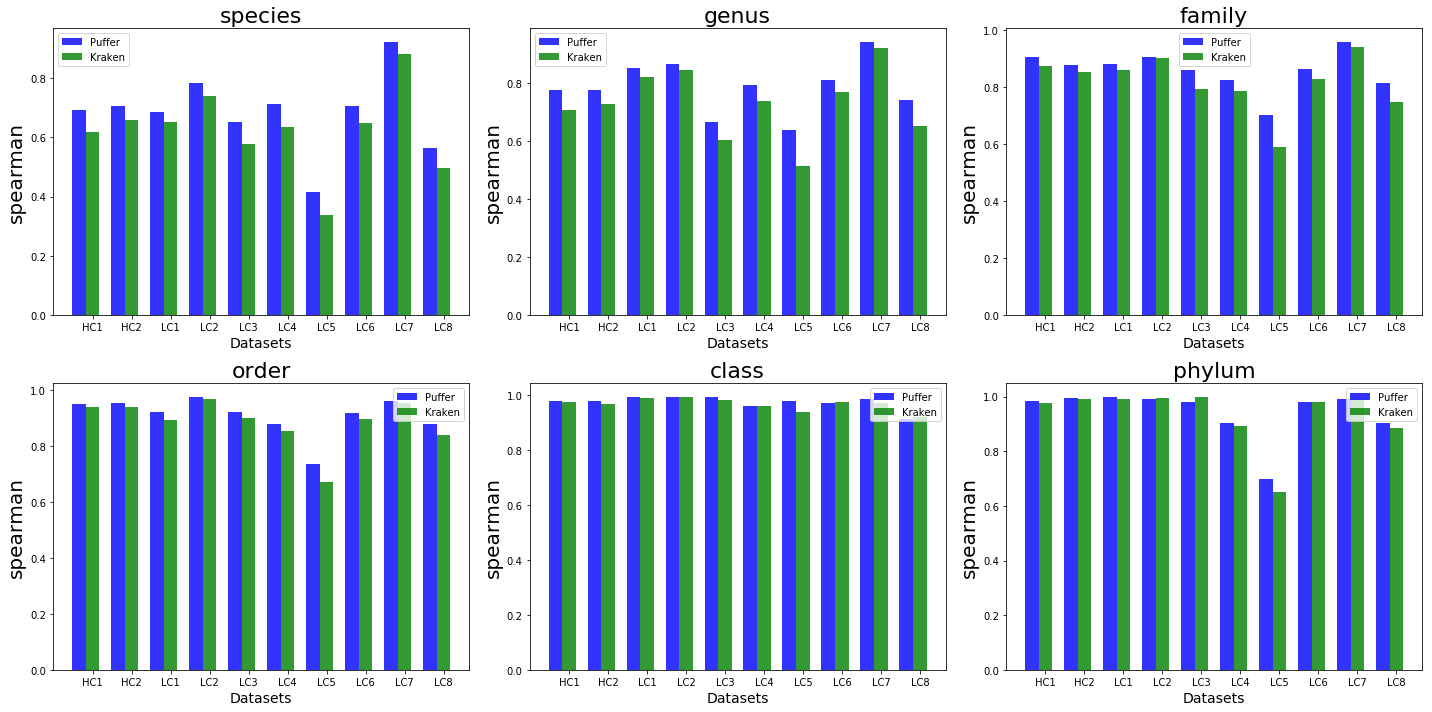



pearson


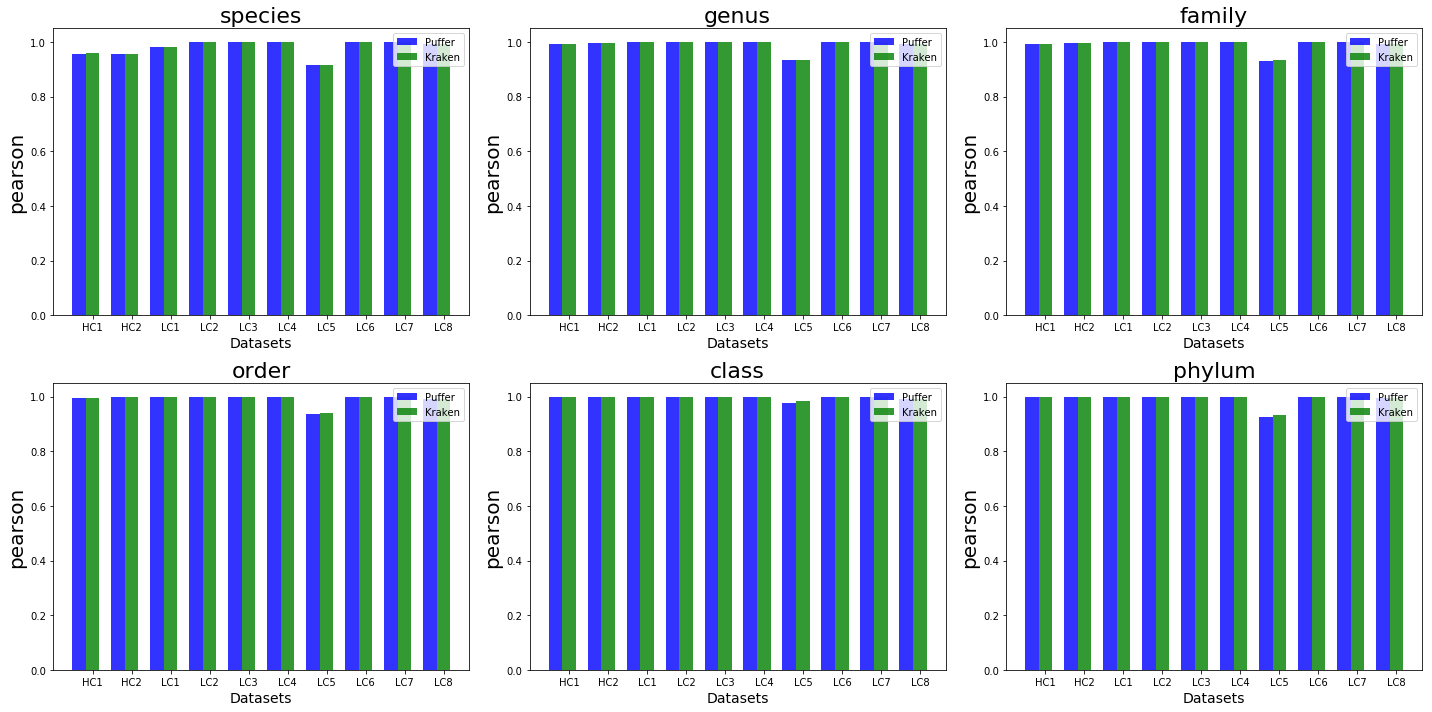



mard


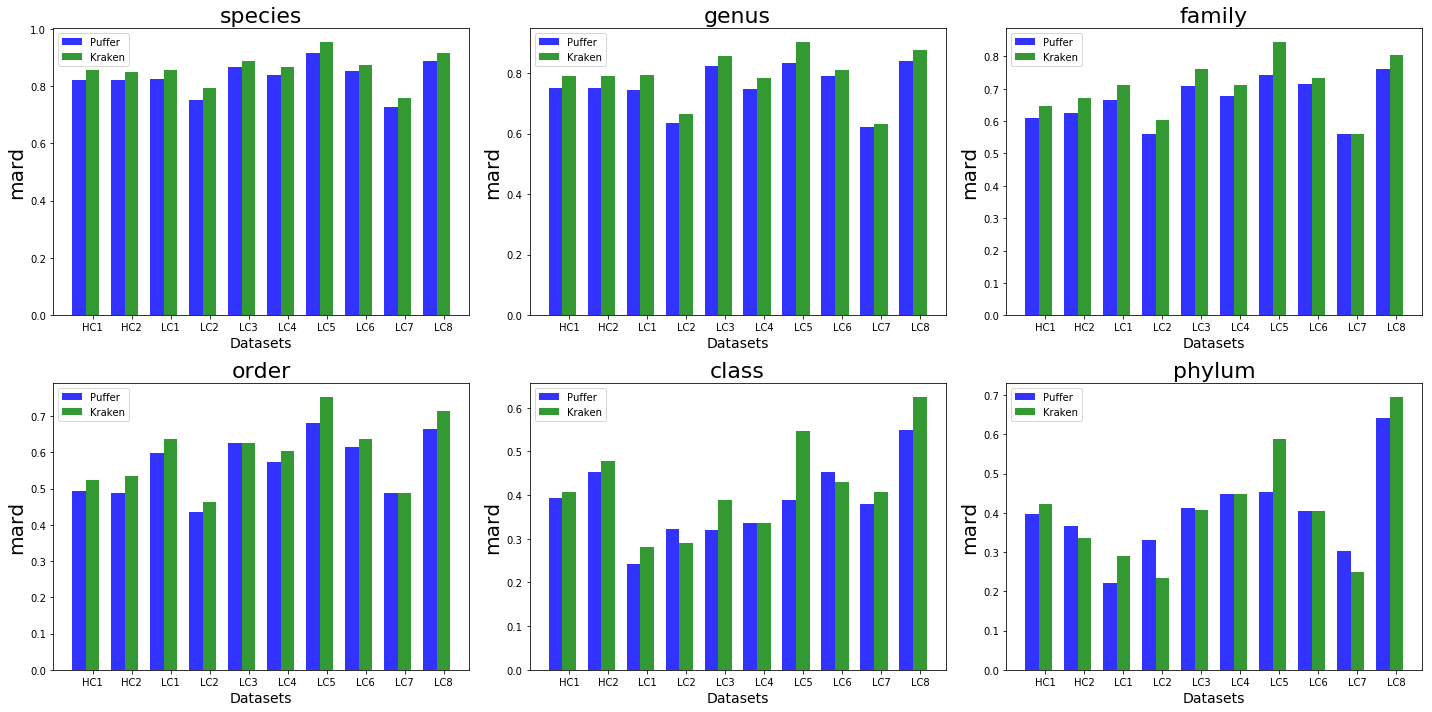



f1


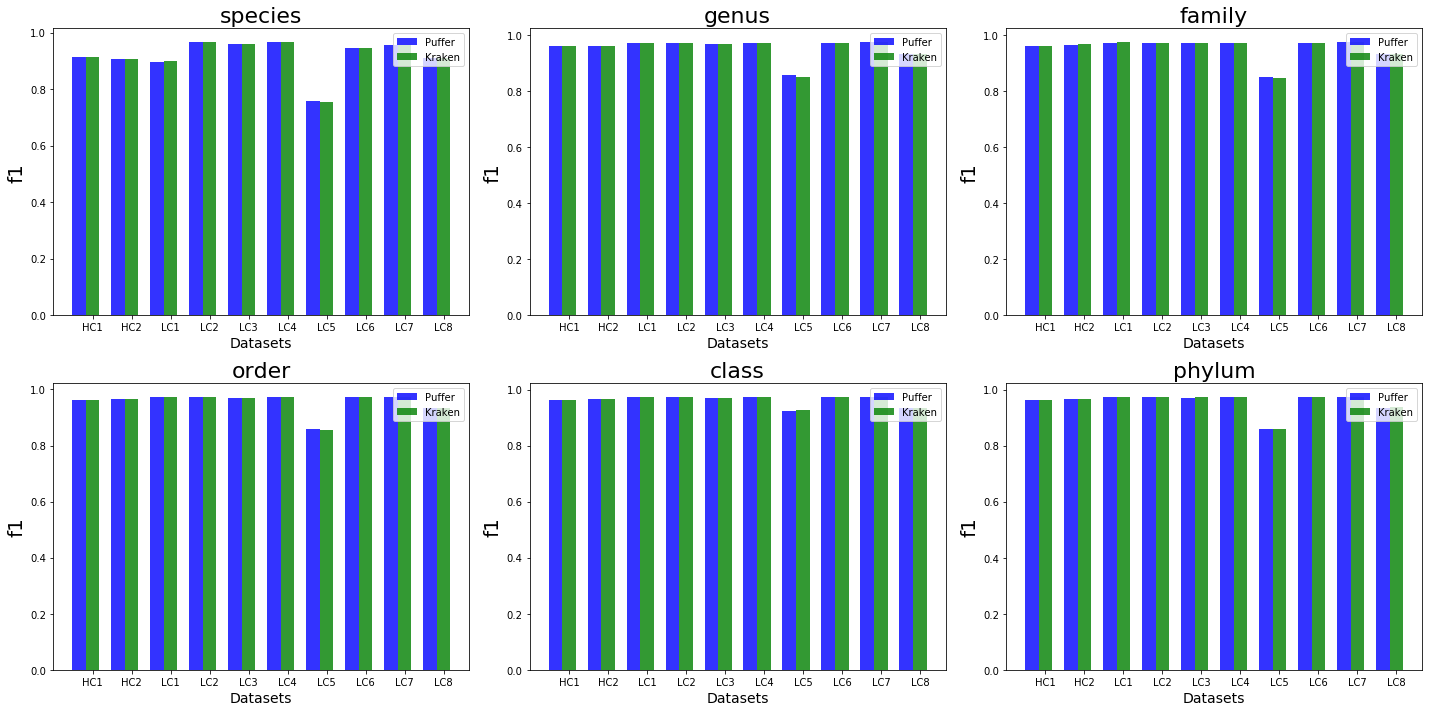

In [302]:
draw_plots(stats_df)

In [316]:
print('Positive is required')
stats_df[['dataset', 'level', 
          'krakpuff_mard_diff', 'puffkrak_spearman_diff', 
          'puffkrak_pearson_diff', 'puffkrak_f1_diff']]

Positive is required


,dataset,level,krakpuff_mard_diff,puffkrak_spearman_diff,puffkrak_pearson_diff,puffkrak_f1_diff
0,HC1,species,0.037050,0.073275,-1.966983e-03,-0.000243
1,HC1,genus,0.041006,0.065952,-1.881289e-04,-0.000079
2,HC1,family,0.038910,0.029599,-2.700102e-04,-0.000573
3,HC1,order,0.031526,0.009694,-1.596978e-04,-0.000814
4,HC1,class,0.014195,0.005669,-1.492031e-05,-0.000993
5,HC1,phylum,0.025906,0.007284,-3.215227e-07,-0.001031
6,HC2,species,0.028695,0.047600,-1.818671e-03,-0.001133
7,HC2,genus,0.041510,0.049884,-4.312480e-04,-0.001022
8,HC2,family,0.045327,0.023877,-1.726936e-04,-0.001349
9,HC2,order,0.046374,0.012570,-6.127707e-05,-0.001454


# 20 percent normalized by read len



spearman


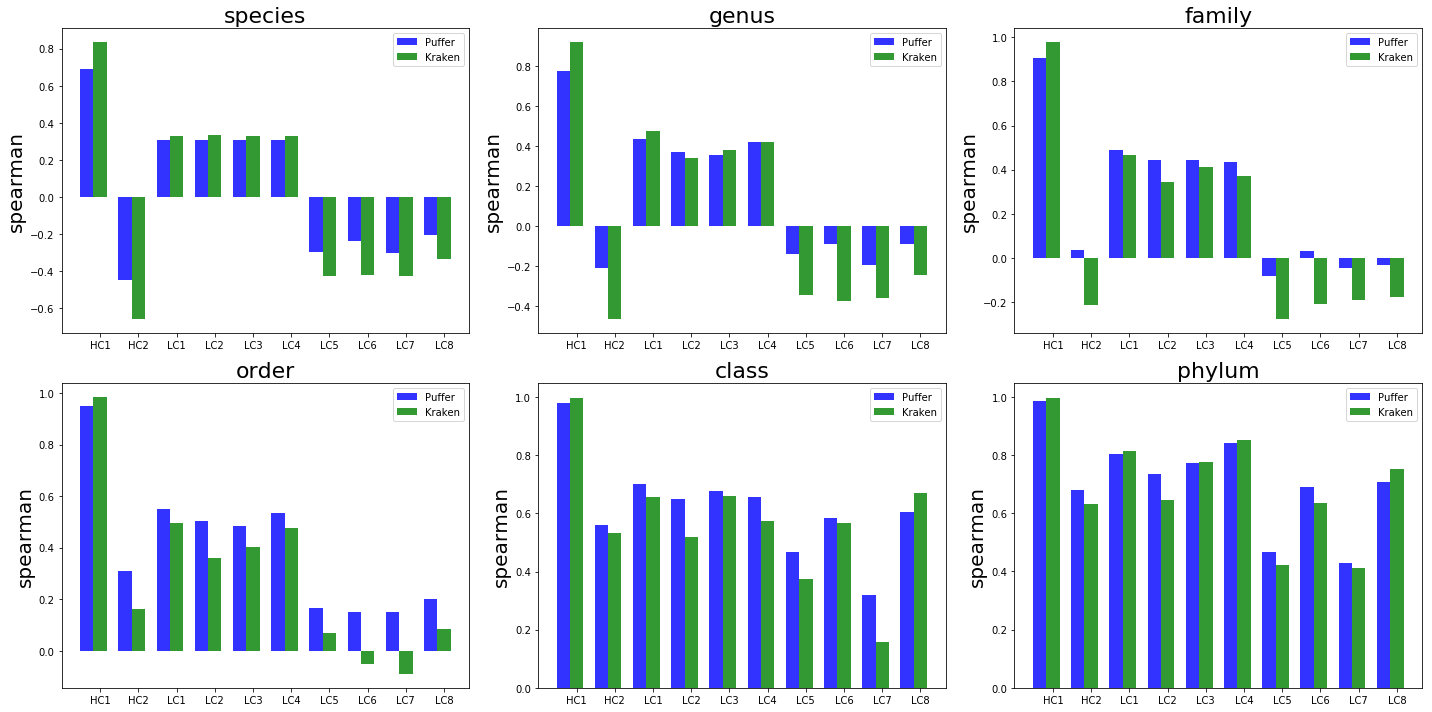



pearson


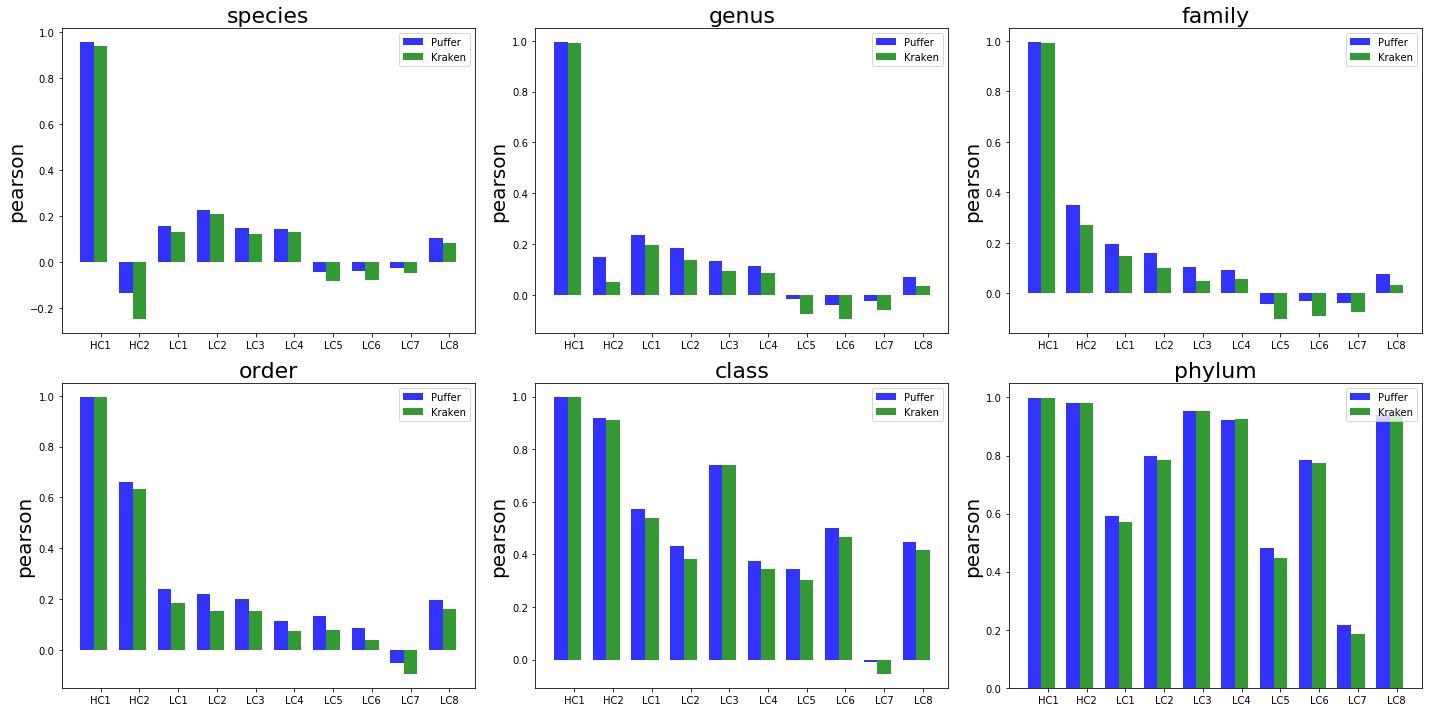



mard


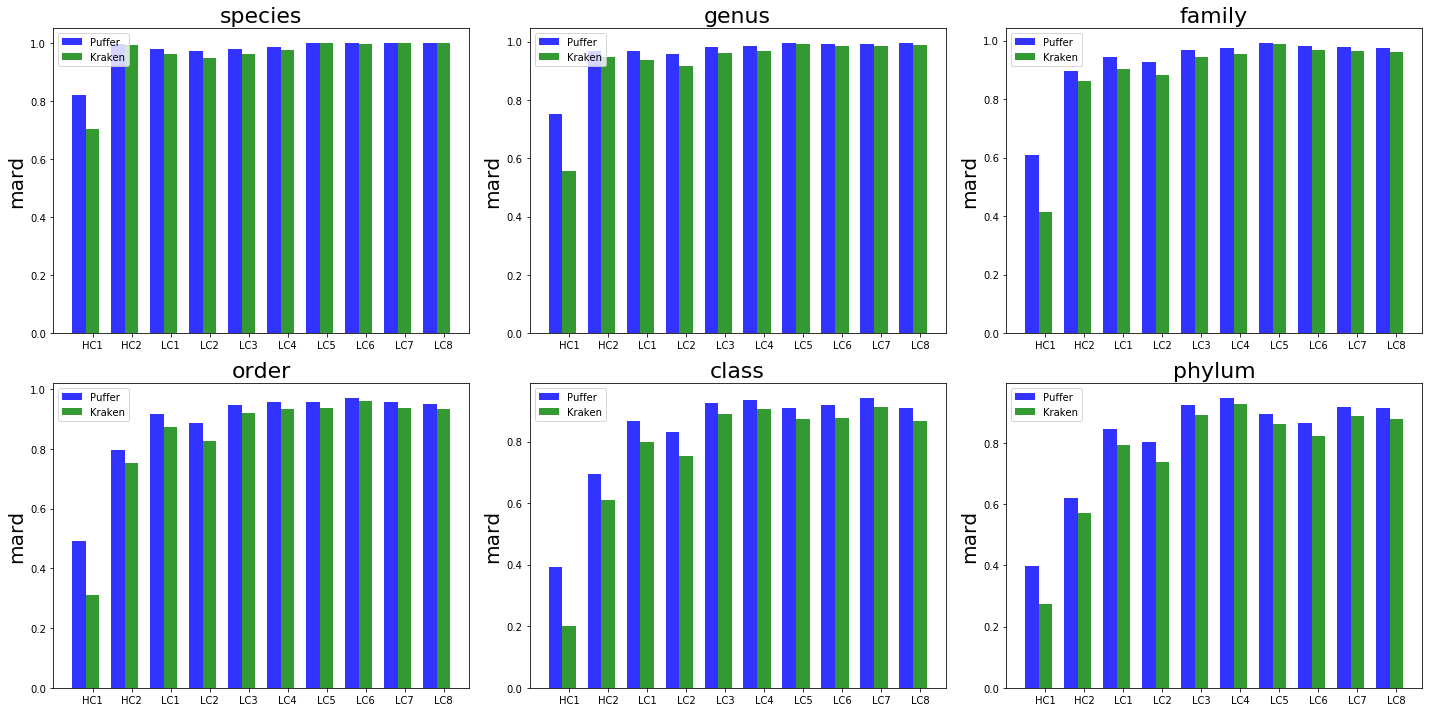



f1


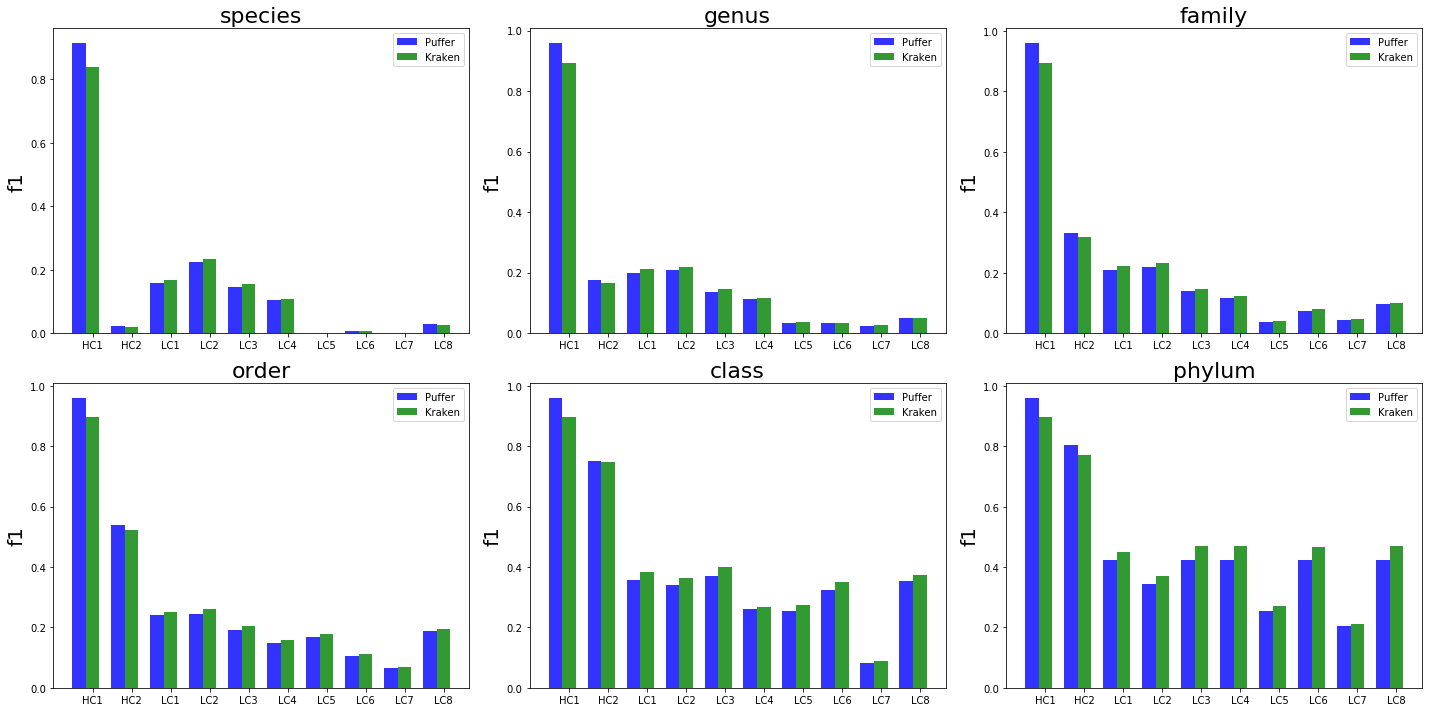

In [345]:
#(stats20_df, kraken20, puffer20) = prepare('/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt', 
#                                                 '/mnt/scratch2/fatemeh/krakpuff/{}_species0_2.out')
draw_plots(stats20_df)